In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.model_selection import GridSearchCV
import os
import ast

from pathlib import Path
import pickle

from surrogates.system import SystemSurrogate
from utils import ax_default

In [3]:
# Load the full SystemSurrogate
save_dir = 'mf_2023-10-25T14.45.43/multi-fidelity'
base_dir = Path('../../results/surrogates')
root_dir = base_dir / save_dir
surr = SystemSurrogate.load_from_file(root_dir / 'sys' / 'sys_final.pkl', root_dir=root_dir)
surr.set_output_dir({'Thruster': None})  # Don't save outputs for testing
sys_qoi = [1, 2, 8, 9]
thruster_qoi = [i-1 for i in sys_qoi]

2023-10-26 11:33:00,480 — [INFO] — surrogates.system.SystemSurrogate    — SystemSurrogate loaded from C:\Users\eckel\Documents\GitHub\HallThrusterPEM\results\surrogates\mf_2023-10-25T14.45.43\multi-fidelity\sys\sys_final.pkl


In [44]:
# Load training set
thruster = surr['Thruster']
xdim, ydim = len(thruster.x_vars), thruster.ydim
xi, yi = thruster.get_training_data()
xtrain, ytrain = np.empty((0, xdim)), np.empty((0, ydim))

# Combine data from multiple model fidelities
for alpha, x in xi.items():
    for i in range(x.shape[0]):
        # Keep highest-fidelity training samples for duplicate x
        diff = np.abs(xtrain - x[i, :])
        idx = np.count_nonzero(diff, axis=-1) == 0  
        if np.any(idx):
            # print(f'{alpha}: i={i}, x={x[i, :]}')
            ytrain[idx, :] = yi[alpha][i, :]  # Should at most only have one True
        else:
            xtrain = np.concatenate((xtrain, x[np.newaxis, i, :]), axis=0)
            ytrain = np.concatenate((ytrain, yi[alpha][np.newaxis, i, :]), axis=0)
ytrain = ytrain[:, thruster_qoi]
xtrain.shape, ytrain.shape

((336, 15), (336, 4))

In [36]:
# Make sure there are no duplicate x's remaining in the training set
diff = np.abs(np.expand_dims(xtrain, axis=0) - np.expand_dims(xtrain, axis=1))
idx = np.count_nonzero(diff, axis=-1) == 0
idx = np.count_nonzero(idx, axis=-1)  # Should be identity matrix of length Nx (each point is only equal to itself)
np.any(idx > 1) 

False

In [39]:
# Load system test set
# with open(Path('../../models/data') / 'test_set.pkl', 'rb') as fd:
#     data = pickle.load(fd)
#     xtest_sys, ytest_sys = data['xt'], data['yt']
xtest_sys, ytest_sys = surr.build_metrics['xt'], surr.build_metrics['yt']
xtest_sys.shape, ytest_sys.shape

((988, 25), (988, 28))

In [40]:
# Get system surrogate prediction
yt_surr = surr(xtest_sys)
yt_surr = yt_surr[:, sys_qoi]   # (Nt, Nq)
yt_surr.shape

(988, 4)

In [42]:
# Convert test set to thruster inputs/outputs
exo_in = surr.graph.nodes['Thruster']['exo_in']
global_in = surr.graph.nodes['Thruster']['global_in']
xtest = np.concatenate((xtest_sys[:, exo_in], ytest_sys[:, global_in]), axis=-1)    # (Nt, 15)
ytest = ytest_sys[:, sys_qoi]                                                       # (Nt, Nq)
xtest.shape, ytest.shape

((988, 15), (988, 4))

Training set R2 values: [0.002095   0.70777417 0.78548211 0.89800132]. Uniform average: 0.5983381509908217
Relative L2 error on test set: [ 4.49052969 15.09617357 39.57724868 45.92575053]
Relative L2 error on training set: [0.31858572 0.22509144 0.38107101 0.31503142]


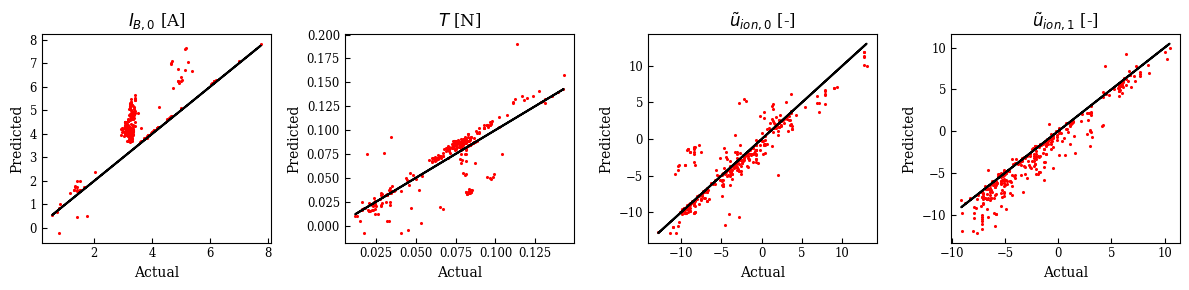

In [60]:
# Test MISC surrogate on training set
model = surr.get_component('Thruster')
ytrain_ridge = model(xtrain)[:, thruster_qoi]
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_surr)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')
rel_error = np.sqrt(np.mean((ytrain - ytrain_ridge)**2, axis=0)) / np.sqrt(np.mean(ytrain**2, axis=0))     # (Nq,)
print(f'Relative L2 error on training set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
labels = [surr.coupling_vars[i].to_tex(units=True) for i in sys_qoi]
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Training set R2 values: [ 0.78738063  0.33031056 -2.57495935  0.12986073]. Uniform average: -0.3318518576998855
Relative L2 error on test set: [0.26406259 0.25491156 1.03596804 1.60591834]
Relative L2 error on training set: [0.10392311 0.21293663 0.75262296 0.6275396 ]


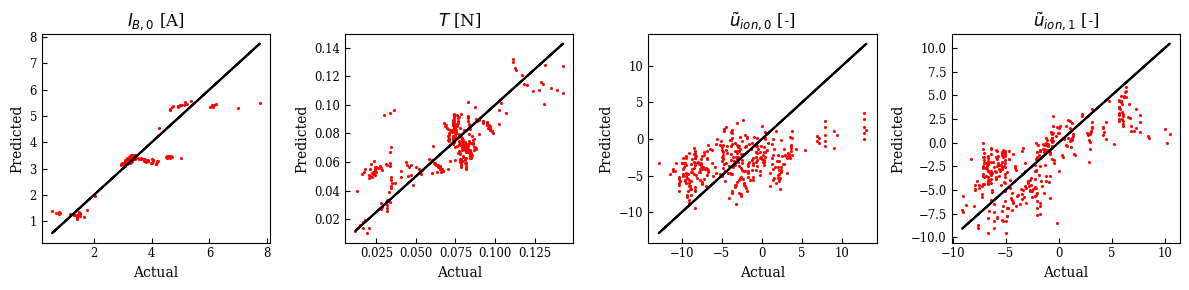

In [64]:
# Test scikit-learn regression
model = Ridge(alpha=0.1)
model.fit(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')
rel_error = np.sqrt(np.mean((ytrain - ytrain_ridge)**2, axis=0)) / np.sqrt(np.mean(ytrain**2, axis=0))     # (Nq,)
print(f'Relative L2 error on training set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END features__degree=2, scaler=StandardScaler();, score=-1417.637 total time=   0.0s
[CV 2/5] END features__degree=2, scaler=StandardScaler();, score=0.606 total time=   0.0s
[CV 3/5] END features__degree=2, scaler=StandardScaler();, score=0.631 total time=   0.0s
[CV 4/5] END features__degree=2, scaler=StandardScaler();, score=-0.211 total time=   0.0s
[CV 5/5] END features__degree=2, scaler=StandardScaler();, score=0.667 total time=   0.0s
[CV 1/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.520 total time=   0.0s
[CV 2/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.582 total time=   0.0s
[CV 3/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.578 total time=   0.0s
[CV 4/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.121 total time=   0.0s
[CV 5/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.612 total time=   0.0s
[CV 1/5] END features__degree=3, scaler=Stand

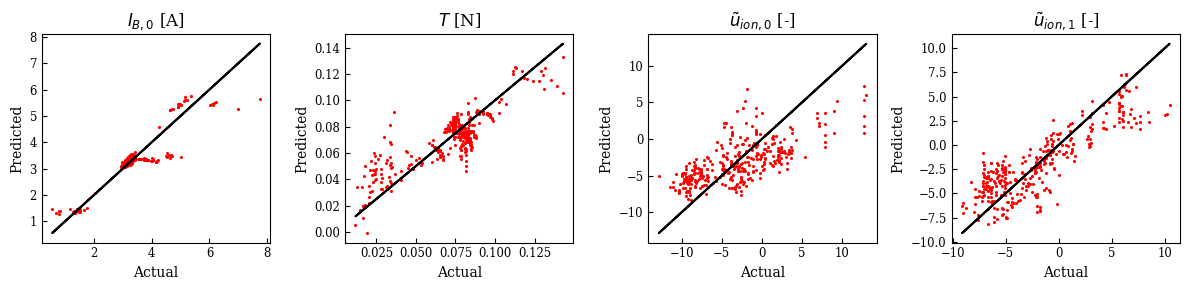

In [65]:
# Test scikit-learn regression
pipe = Pipeline([('scaler', StandardScaler()),
                  ('features', PolynomialFeatures()),
                  ('model', Ridge(alpha=1))])
params = {'features__degree': [2, 3, 4],
          'scaler': [StandardScaler(), MaxAbsScaler()]
          }
model = GridSearchCV(pipe, params, cv=5, verbose=3)
model.fit(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')
rel_error = np.sqrt(np.mean((ytrain - ytrain_ridge)**2, axis=0)) / np.sqrt(np.mean(ytrain**2, axis=0))     # (Nq,)
print(f'Relative L2 error on training set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-4.177 total time=   0.0s
[CV 2/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-6.374 total time=   0.0s
[CV 3/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-11.367 total time=   0.0s
[CV 4/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-236.249 total time=   0.0s
[CV 5/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-4.256 total time=   0.0s
[CV 1/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-2.014 total time=   0.0s
[CV 2/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-2.288 total time=   0.0s
[CV 3/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-3.472 total time=   0.0s
[CV 4/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-200.668 total time=   0.0s
[CV 5/5] END model__alpha=0.01, model__kernel__l

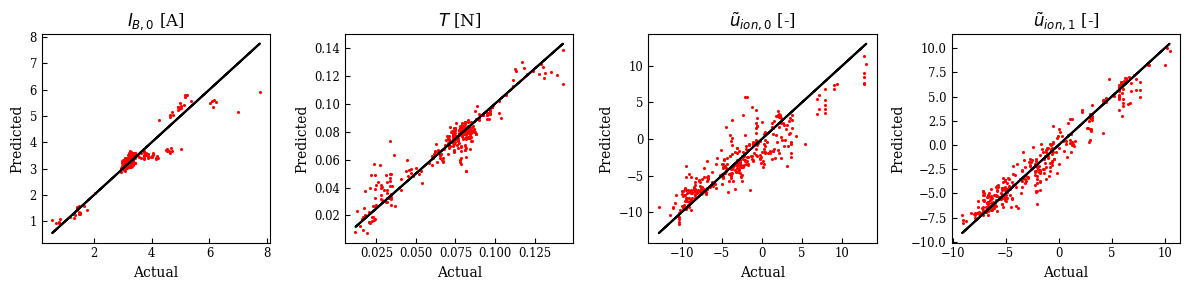

In [66]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

pipe = Pipeline([('scaler', MaxAbsScaler()),
                  ('model', GaussianProcessRegressor(n_restarts_optimizer=0, kernel=RBF(length_scale_bounds='fixed')))])
params = {'model__alpha': [1e-2, 1e-1],
          'model__kernel__length_scale': [0.01, 0.1, 1, 10]
          }
model = GridSearchCV(pipe, params, cv=5, verbose=3)
model.fit(xtrain, ytrain)
r2 = model.score(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')
rel_error = np.sqrt(np.mean((ytrain - ytrain_ridge)**2, axis=0)) / np.sqrt(np.mean(ytrain**2, axis=0))     # (Nq,)
print(f'Relative L2 error on training set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Iteration 1, loss = 9.85594918
Iteration 2, loss = 8.84010713
Iteration 3, loss = 7.99363570
Iteration 4, loss = 7.35563651
Iteration 5, loss = 6.95832165
Iteration 6, loss = 6.68360744
Iteration 7, loss = 6.51005288
Iteration 8, loss = 6.38041915
Iteration 9, loss = 6.28347148
Iteration 10, loss = 6.20908123
Iteration 11, loss = 6.14451657
Iteration 12, loss = 6.09209377
Iteration 13, loss = 6.04131489
Iteration 14, loss = 6.00069860
Iteration 15, loss = 5.96017432
Iteration 16, loss = 5.92584756
Iteration 17, loss = 5.89364307
Iteration 18, loss = 5.86335816
Iteration 19, loss = 5.83388704
Iteration 20, loss = 5.80806586
Iteration 21, loss = 5.78111330
Iteration 22, loss = 5.75645744
Iteration 23, loss = 5.73497333
Iteration 24, loss = 5.71168271
Iteration 25, loss = 5.69030064
Iteration 26, loss = 5.67011258
Iteration 27, loss = 5.64946449
Iteration 28, loss = 5.62994980
Iteration 29, loss = 5.60990748
Iteration 30, loss = 5.58939751
Iteration 31, loss = 5.56769231
Iteration 32, los

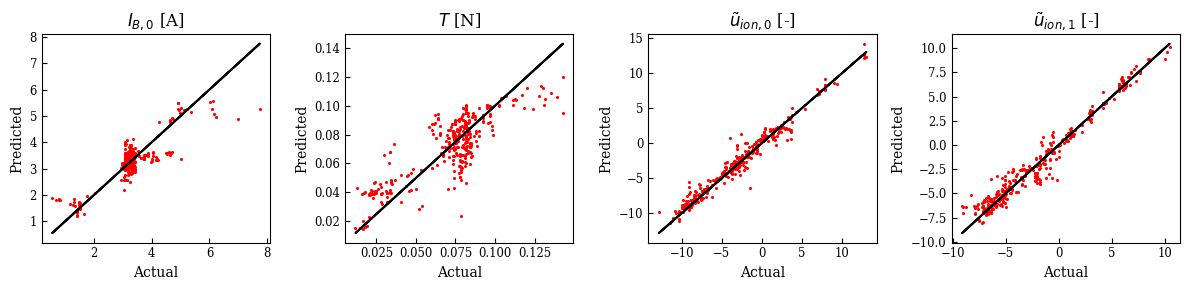

In [67]:
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([('scaler', MaxAbsScaler()),
                  ('model', MLPRegressor(activation='tanh', hidden_layer_sizes=(50, 10), alpha=1e-2, learning_rate_init=0.001, max_iter=4000, verbose=True, tol=1e-12, batch_size=64, n_iter_no_change=50, validation_fraction=0.1))])
# params = {'model__hidden_layer_sizes': [(20, 10), (20, 10, 5), (50, 30, 10), (10, 5)],
#           'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
#           'model__learning_rate_init': [1e-3, 1e-2, 1e-1]
#           }
# model = GridSearchCV(pipe, params, cv=10, verbose=3)
model = pipe
model.fit(xtrain, ytrain)
r2 = model.score(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')
rel_error = np.sqrt(np.mean((ytrain - ytrain_ridge)**2, axis=0)) / np.sqrt(np.mean(ytrain**2, axis=0))     # (Nq,)
print(f'Relative L2 error on training set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

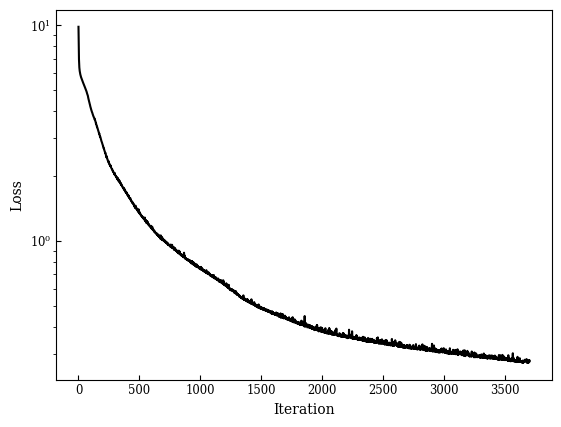

In [68]:
l = model['model'].loss_curve_
fig, ax = plt.subplots()
ax.plot(l, '-k')
ax.set_yscale('log')
ax_default(ax, 'Iteration', 'Loss', legend=False)
plt.show()

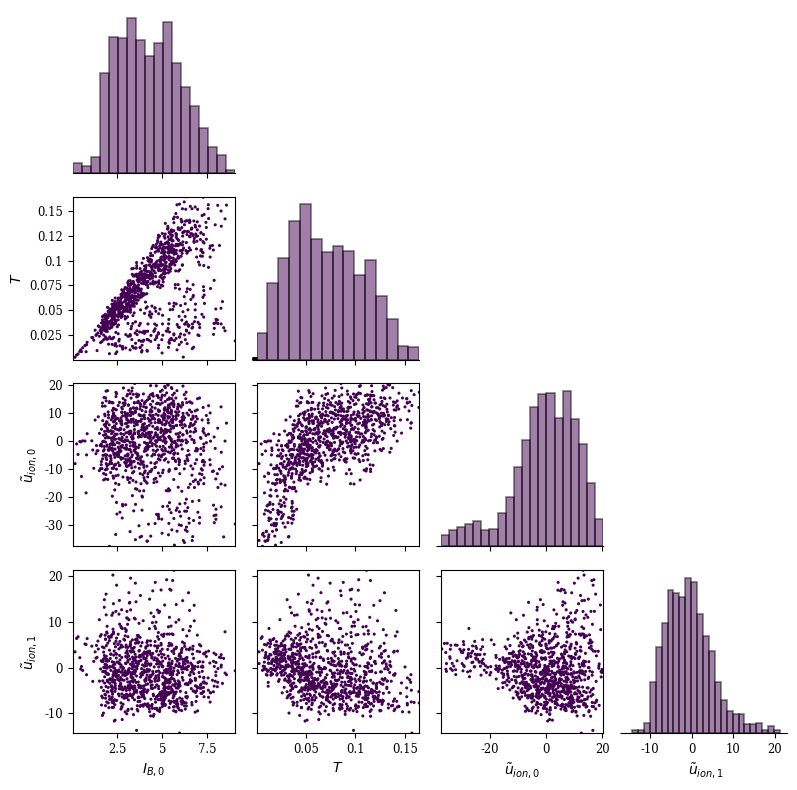

In [91]:
# Scatter plots of input/output spaces
from uq.mcmc import ndscatter

# labels = [var.to_tex() for var in surr['Thruster'].x_vars]
labels = [var.to_tex() for i, var in enumerate(surr.coupling_vars) if i in sys_qoi]
fig, ax = ndscatter(ytest, labels=labels, subplot_size=2)
plt.show()

In [96]:
# Find what is causing negative thrust and NaN cases
import os
save_dir = 'build_2023-07-18T01.48.39'
root_dir = Path('../surrogates') / save_dir / 'components' / 'Thruster'
x = np.zeros((0, 14))
y = np.zeros((0, 26))
for f in os.listdir(root_dir):
    if f.endswith('.pkl'):
        with open(root_dir / f, 'rb') as fd:
            data = pickle.load(fd)
            x = np.concatenate((x, data['x']), axis=0)
            y = np.concatenate((y, data['y']), axis=0)
x.shape, y.shape

((6476, 14), (6476, 26))

In [108]:
nan_idx = np.where(np.any(np.isnan(y), axis=-1))[0]
neg_idx = np.where(y[:, 1] < 0)[0]
nan_idx.shape, neg_idx.shape

((77,), (121,))

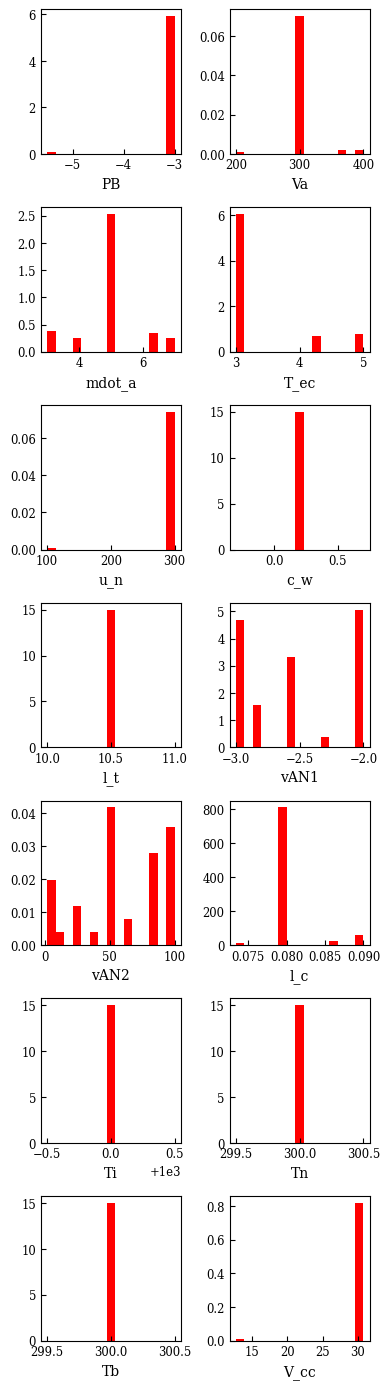

In [135]:
fig, axs = plt.subplots(7, 2)
curr_idx = 0
thruster_idx = [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15]
labels = [str(var) for i, var in enumerate(surr.exo_vars) if i in thruster_idx] + ['V_cc']
for i in range(7):
    for j in range(2):
        ax = axs[i, j]
        ax.hist(x[nan_idx, curr_idx], color='red', linewidth=1.2, density=True, bins=15)
        ax_default(ax, labels[curr_idx], '', legend=False)
        curr_idx += 1
fig.set_size_inches(4, 14)
fig.tight_layout()
plt.show()